# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="/home/luis-ferro/git/personal/deep-reinforcement-learning/p1_navigation/Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Define Q-networks

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128, fc3_units=64):
        super(QNetwork, self).__init__()
        self.seed = seed
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.do1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.do1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

### Define Memory buffer

In [8]:
from collections import namedtuple, deque
import random


class ReplayBuffer:
    
    def __init__(self, buffer_size, batch_size, seed, device):
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.device = device
        
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        n_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        
        return (states, actions, n_states, rewards, dones)
    
    def __len__(self):
        return len(self.memory)

### Define Q-Agent

In [9]:
import torch.optim as optim

class Agent:
    
    def __init__(self, 
                 state_size, 
                 action_size, 
                 seed,
                 buffer_size=int(1e5), 
                 batch_size=64,
                 device='cpu',
                 lr=5e-4,
                 gamma=0.99,
                 tau=1e-3,
                 update_every=4,
                 use_double_q=False):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        self.lr = lr
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.device = device
        self.update_every = update_every
        self.gamma = gamma
        self.tau = tau
        self.use_double_q = use_double_q
        
        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr, amsgrad=True)
        
        # Replay memory
        self.memory = ReplayBuffer(buffer_size, batch_size, seed, device)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        # save to experience buffer
        self.memory.add(state, action, reward, next_state, done)
        
        # update every n time steps
        self.t_step = (self.t_step + 1) & self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)
                
    def learn(self, experiences):
        states, actions, next_states, rewards, dones = experiences
        
        # compute the targets as per formula
        Q_targets_next = self.qnetwork_target(next_states).detach()
        
        if self.use_double_q:
            Q_local_actions = self.qnetwork_local(next_states).detach().argmax(1)
            Q_targets_next = Q_targets_next[Q_local_actions]
        else:
            Q_targets_next = Q_targets_next.max(1)[0].unsqueeze(1)
        
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        
        # compute expected Q values from the local Q network
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # backprop step
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # update the target network weights 
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)
        
        
    def soft_update(self, local, target, tau):
        # The idea here is to update target weights slighlty in the direction
        # of the local network. The tau parameter determines what proportion
        # of each network to use. Small values of tau makes the target network
        # weights more important than local.
        for target_param, local_param in zip(target.parameters(), local.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)
            
    def act(self, state, eps=0.):
        
        state = torch.from_numpy(state).float().to(self.device)
        self.qnetwork_local.eval()
        
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
            
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.randint(self.action_size)
            

### DQN Algorihm

In [10]:
from tqdm import tqdm

def dqn(agent, env, brain_name, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    with tqdm(total=n_episodes) as progress:
        for i_episode in range(1, n_episodes + 1):
            env_info = env.reset(train_mode=True)[brain_name]
            state = env_info.vector_observations[0]
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                env_info = env.step(action)[brain_name]
                next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break

            eps = max(eps_end, eps * eps_decay)
            scores_window.append(score)
            scores.append(score)
            progress.set_postfix({"Avg. Score": f"{np.mean(scores_window):.2f}"})
            progress.update()

            if np.mean(scores_window) >= 13.0:
                print(f"Environment solved at {i_episode} episodes with Avg. score: {np.mean(scores_window):.2f}")
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                break
    return scores

In [11]:
%%time
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

state_size = env_info.vector_observations[0].shape[0]
action_size = brain.vector_action_space_size
seed = 1234
device = "cuda" if torch.cuda.is_available() else "cpu"

agent = Agent(state_size, action_size, seed, buffer_size=int(1e6), batch_size=64, tau=5e-3, lr=1e-3, update_every=4, device=device)

scores = dqn(agent, env, brain_name, n_episodes=2000)

 39%|███▉      | 776/2000 [27:35<43:30,  2.13s/it, Avg. Score=13.02] 

Environment solved at 776 episodes with Avg. score: 13.02
CPU times: user 22min 30s, sys: 28.9 s, total: 22min 59s
Wall time: 27min 36s


In [31]:
import matplotlib.pyplot as plt

def plot_scores(scores):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111)
    
    x = np.arange(len(scores))
    y = scores
    
    plt.plot(x, y, label="avg. scores")
    
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.title("Agent progress over episodes")
    plt.show()

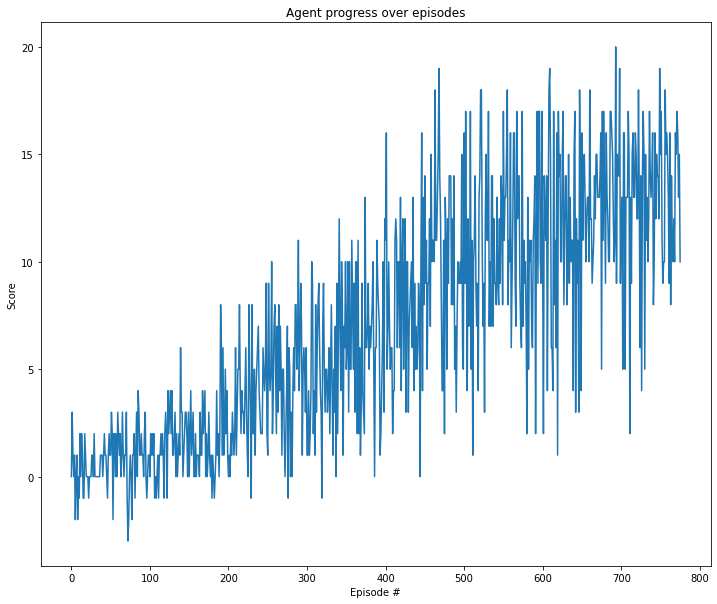

In [32]:
plot_scores(scores)

### Let's observe the agent playing

In [35]:
def play(agent, env, n_episodes=5, max_t=1000, eps=0.):
    scores = []
    with tqdm(total=n_episodes) as progress:
        for i_episode in range(1, n_episodes + 1):
            env_info = env.reset(train_mode=False)[brain_name]
            state = env_info.vector_observations[0]
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                env_info = env.step(action)[brain_name]
                next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
                state = next_state
                score += reward
                if done:
                    break

            scores.append(score)
            progress.set_postfix({"Avg. Score": f"{np.mean(scores):.2f}"})
            progress.update()

In [36]:
play(agent, env)

100%|██████████| 5/5 [02:30<00:00, 30.02s/it, Avg. Score=11.20]


### Let's try with Double DQN

In [38]:
ddqn_agent = Agent(
    state_size, 
    action_size, 
    seed, 
    buffer_size=int(1e6), 
    batch_size=64, 
    tau=5e-3, 
    lr=1e-3, 
    update_every=4,
    use_double_q=True,
    device=device)

ddqn_scores = dqn(agent, env, brain_name, n_episodes=2000)

 23%|██▎       | 451/2000 [17:58<1:01:44,  2.39s/it, Avg. Score=13.05]

Environment solved at 451 episodes with Avg. score: 13.05


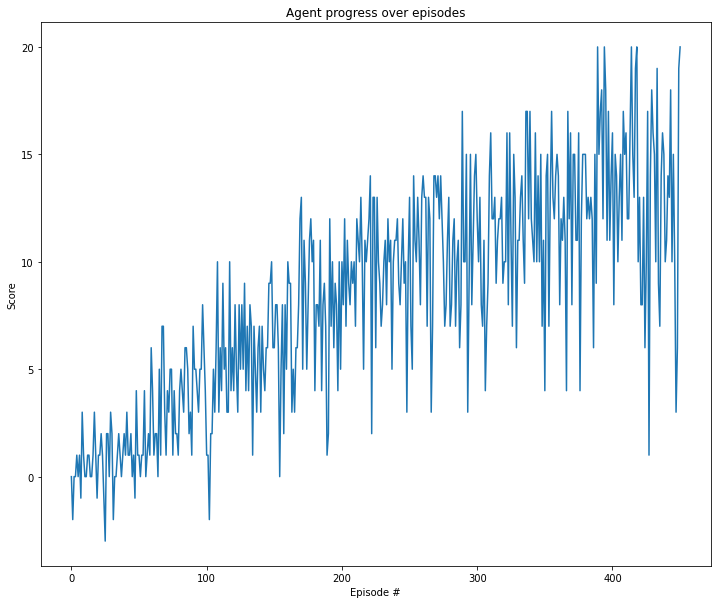

In [39]:
plot_scores(ddqn_scores)

In [41]:
play(ddqn_agent, env)

100%|██████████| 5/5 [02:30<00:00, 30.01s/it, Avg. Score=0.00]
